In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, differential_evolution
import pyfits
from astropy.modeling.models import Voigt1D
import warnings
from __future__ import print_function
from pylab import *
import math
from astropy.io import fits
from astropy.table import Table

from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=12, usetex=True)

%matplotlib inline

### Stars to fit

**HeII:** GJ 628, GJ 887, GJ 1061, and HD 173739

**Not sure yet:** G 75-55, GJ 173, LP 5-282, 2MASSJ02001277-0840516, GJ 3470, LHS 1140,  GJ 676 A, GJ 649, GJ 674, GJ 729

**LyA:** K2-25


In [28]:
hdu[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
NEXTEND =                    1 / Number of standard extensions                  
DATE    = '2018-05-12'         / date this file was written (yyyy-mm-dd)        
FILENAME= 'ldab32ehq_x1d.fits' / name of file                                   
FILETYPE= 'SCI      '          / type of data found in data file                
                                                                                
TELESCOP= 'HST'                / telescope used to acquire data                 
INSTRUME= 'COS   '             / identifier for instrument used to acquire data 
EQUINOX =               2000.0 / equinox of celestial coord. system             
                            

In [29]:
hdu = pyfits.open("Spectra/G75-55/ldab32ehq_x1d.fits")
wave = np.ravel(hdu[1].data["WAVELENGTH"])
flux = np.ravel(hdu[1].data["FLUX"])
err = np.ravel(hdu[1].data["ERROR"])

print(len(wave))
print(len(flux))

#hdulist = fits.open("Spectra/G75-55/ldab32edq_x1d.fits")
#tbdata = hdulist[1].data
#print(Table(tbdata))

star = "G75-55"
c = 299792458e10
#RV = -31.07 * (10 ** 13)
#wave = wave / (1 + RV / c)
print(wave)
print(flux[np.where(wave<1395)])  #np.where((wave<1642)&(wave>1638))])
print(flux)
print(err)
print(tbdata.dtype.names)

32768
32768
[ 1562.75692343  1562.76917072  1562.78141802 ...,  1575.0701422
  1575.08238037  1575.09461854]
[  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,  -2.18228394e-17
  -2.18244904e-17  -2.18259546e-17]
[ 0.  0.  0. ...,  0.  0.  0.]
[  8.89821155e-15   8.89821155e-15   8.89821155e-15 ...,   7.28482470e-15
   7.28486282e-15   7.28490093e-15]
('SEGMENT', 'EXPTIME', 'NELEM', 'WAVELENGTH', 'FLUX', 'ERROR', 'GROSS', 'GCOUNTS', 'NET', 'BACKGROUND', 'DQ', 'DQ_WGT', 'DQ_OUTER', 'BACKGROUND_PER_PIXEL', 'NUM_EXTRACT_ROWS', 'ACTUAL_EE', 'Y_LOWER_OUTER', 'Y_UPPER_OUTER', 'Y_LOWER_INNER', 'Y_UPPER_INNER')


(1375, 1400)

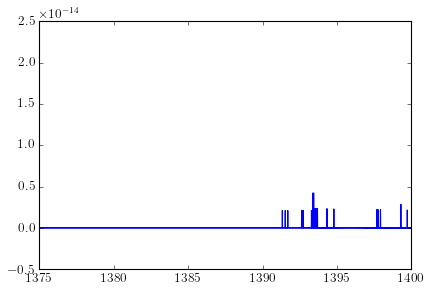

In [30]:
plt.plot(wave,flux)
#plt.xlim(1638,1642)
plt.xlim(1375,1400)

In [33]:
def ready_lsf(orig_lsf_wave, orig_lsf , grating_disp, data_wave):
    data_wave_spacing = data_wave[1]-data_wave[0] # number of Å per pixel
    data_wave_length = len(data_wave) # number of wavelength values
    lsf_lam_min = np.round(np.min(orig_lsf_wave*grating_disp)/data_wave_spacing) * data_wave_spacing
    lsf_lam_onesided = np.arange(lsf_lam_min,0,data_wave_spacing)  ### Make sure it's even and doesn't include zero
    if len(lsf_lam_onesided) % 2 != 0:
        lsf_lam_onesided = lsf_lam_onesided[1::] # get rid of the first element of the array

    lsf_lam_flipped = lsf_lam_onesided[::-1]
    lsf_lam_pluszero=np.append(lsf_lam_onesided,np.array([0]))
    lsf_lam=np.append(lsf_lam_pluszero,lsf_lam_flipped) # should be odd

    lsf_interp = np.interp(lsf_lam,orig_lsf_wave*grating_disp,orig_lsf/np.sum(orig_lsf))
    lsf_interp_norm = lsf_interp/np.sum(lsf_interp) # I don't know why I do np.sum() for normalization...

    if data_wave_length < len(lsf_interp_norm):
        lsf_interp_norm = np.delete(lsf_interp_norm,np.where(lsf_interp_norm == 0))
        lsf_interp_norm = np.insert(lsf_interp_norm,0,0)
        lsf_interp_norm = np.append(lsf_interp_norm,0)

    return lsf_interp_norm

##################################################################

lsf = np.loadtxt("HST_Gratings/cos_G130M.txt", skiprows=1)
dispersion = wave[1]-wave[0] # number of Å per pixel
lsf_kernel = ready_lsf(lsf[:,0], lsf[:,1], dispersion, wave)

##################################################################

#Defining a functions
def gaussian(x, amp, cen, wid):
    model =  amp*np.exp(-(x-cen)**2/(2*wid**2))
    model_convolved = np.convolve(model, lsf_kernel, mode='same')
    return model_convolved

def double_gauss(x, amp1, cen1, wid1, amp2, cen2, wid2):
    model = amp1*np.exp(-(x-cen1)**2/(2*wid1**2)) + amp2*np.exp(-(x-cen2)**2/(2*wid2**2))
    model_convolved = np.convolve(model, lsf_kernel, mode='same')
    return model_convolved

##################################################################

def sse_g(parameterTuple):
    warnings.filterwarnings("ignore") # do not print warnings by genetic algorithm
    g_fit = gaussian(wave, *parameterTuple)
    return np.sum((flux - g_fit)**2) #/ g_fit)

def generate_p0_g(peak_flux, line, window):
    parameterBounds = []
    parameterBounds.append([(peak_flux)*0.9, (peak_flux)*1.1]) # parameter bounds for amp  
    parameterBounds.append([line, line]) # parameter bounds for cen
    parameterBounds.append([0, 0.1]) # parameter bounds for wid
    #parameterBounds.append([0, 0]) # parameter bounds for c
    # "seed" the numpy random number generator for repeatable results
    result = differential_evolution(sse_g, parameterBounds)#, seed=2019)
    return result.x

def sse_dg(parameterTuple):
    warnings.filterwarnings("ignore") # do not print warnings by genetic algorithm
    dg_fit = double_gauss(wave, *parameterTuple)
    return np.sum((flux - dg_fit)**2) #/ dg_fit)

def generate_p0_dg(amp1, amp2, cen1, cen2, window):
    parameterBounds = []
    parameterBounds.append([(amp1)*0.9, (amp1)*1.1]) # parameter bounds for amp  
    parameterBounds.append([cen1, cen1]) # parameter bounds for cen
    parameterBounds.append([0, 0.1]) # parameter bounds for wid
    parameterBounds.append([(amp2)*0.9, (amp2)*1.1]) # parameter bounds for amp  
    parameterBounds.append([cen2, cen2]) # parameter bounds for cen
    parameterBounds.append([0, 0.1]) # parameter bounds for wid
    #parameterBounds.append([0, 0]) # parameter bounds for c
    # "seed" the numpy random number generator for repeatable results
    result = differential_evolution(sse_dg, parameterBounds)#, seed=2019)
    return result.x

In [34]:
print(np.max(line_window[0]))
print(wave)

mask = np.logical_and(wave<(line_waves[0][-1]+np.max(line_window[0])), wave>(line_waves[0][0]-np.max(line_window[0])))
print(mask)
print(len(mask))
print(len(flux))
#print(wave[mask])
#print(flux[mask])

1
[ 1562.75692343  1562.76917072  1562.78141802 ...,  1575.0701422
  1575.08238037  1575.09461854]
[False False False ..., False False False]
32768
32768


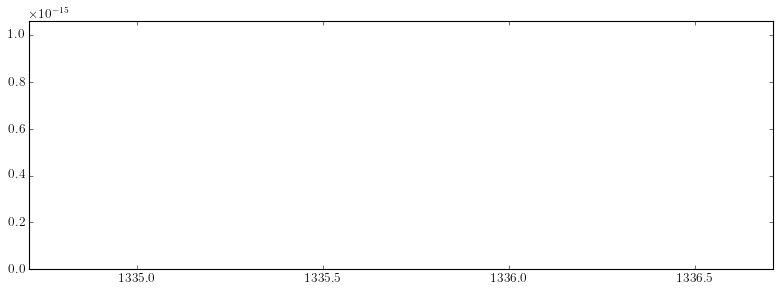

In [36]:
line_names = ["SiIII", "NV", "SiII", "CII", "SiIV", "CIV", "HeII", "MgII",]
line_waves = [[1206.50], [1238.82,1242.8060], [1260.42,1265.00], [1335.71],  
              [1393.76,1402.77], [1548.19,1550.78], [1640.4], [2796.35,2803.53]]
line_window = [[1], [2,2], [0.7,1], [0.7], [1,1], [1,1], [1], [20]]
#note: 1265.00 represents both 1264.74 and 1265.00
#note: 2800.00 represents both 2796.35 and 2803.53

line_names = ["CII"]
line_waves = [[1335.71]]
line_window = [[1]]

#print(wave[(wave<(line_waves[0][-1]+np.max(line_window[0]))) & (wave>(line_waves[0][0]-np.max(line_window[0])))])
#print(flux[(wave<(line_waves[0][-1]+np.max(line_window[0]))) & (wave>(line_waves[0][0]-np.max(line_window[0])))])

#plot the raw data to see whats around it
plt.figure(figsize=(12,4))
plt.plot(wave[(wave<(line_waves[0][-1]+np.max(line_window[0]))) & (wave>(line_waves[0][0]-np.max(line_window[0])))], 
         flux[(wave<(line_waves[0][-1]+np.max(line_window[0]))) & (wave>(line_waves[0][0]-np.max(line_window[0])))])
plt.xlim(line_waves[0][0]-np.max(line_window),line_waves[0][-1]+np.max(line_window))
plt.ylim(0,1.1*9.640308440905302e-16)
plt.ticklabel_format(useOffset=False)
#plt.xlim(1264, 1266)
plt.show()

## Plotting each line for a target individually and getting fluxes

CII
1335.71
Peak Spectral Flux 6.29933e-15
Window:  1.0
Chi2:  6.73959580334e+13
Max_mag -15.0
GAUSSIAN FLUX TOTAL:  7.03394745563e-16


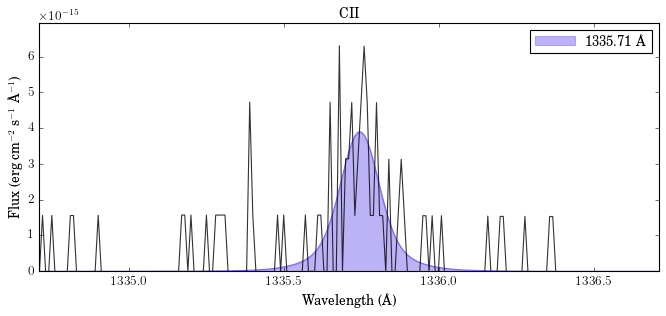

In [216]:
## ONE GRAPH AT A TIME ##

g_fluxes = []
g_amps = []
g_sigmas = []

colors=["mediumslateblue", "firebrick", "peachpuff"]

for i in range(len(line_names)):
    ##########################
    plt.figure(figsize=(10,4))
    plt.xlabel("Wavelength (\AA)")
    plt.xlim(line_waves[i][0]-np.max(np.array(line_window[i])),line_waves[i][-1]+np.max(np.array(line_window[i])))
    plt.title(r"%s" % line_names[i])
    plt.ticklabel_format(useOffset=False)
    ##########################
    
    print(line_names[i])
    
    line_total_int_g = []
    all_orders_of_mag = []
    
    for j in range(len(line_waves[i])):
        
        line=line_waves[i][j]
        print(line)

        max_window = float(line_window[i][j])
        min_window = float(line_window[i][j])
        #print("Window: ", window)

        peak_flux = np.max(flux[(wave<(line+0.2)) & (wave>(line-0.2))])
        #avg_line_flux = np.mean(flux[(wave<(line_waves[i]+window)) & (wave>(line_waves[i]-window))])
        #amp_guess = line_amps[i]

        print("Peak Spectral Flux", peak_flux)
        #print("Avg Spectral Line Flux", avg_line_flux)

        ##########################
        
        window = max_window

        while window >= min_window:
            print("Window: ", window)
            try:
                if line == 1265:
                    print("Fitting a double gaussian")
                    amp1 = np.max(flux[(wave<1264.9) & (wave>1264.5)])
                    amp2 = np.max(flux[(wave<1265.3) & (wave>1264.9)])
                    
                    p0_dg = generate_p0_dg(amp1, amp2, 1264.74, 1265.00, window)
                    
                    print(amp1, amp2)
                    #param_bounds=([-np.inf,1264.5,-np.inf,-np.inf,1264.8,-np.inf,-np.inf],[np.inf,1265.8,np.inf,np.inf,1265.2,np.inf,np.inf])
                    popt_g, pcov_g = curve_fit(double_gauss, np.array(wave[(wave<1265.5) & (wave>1264)]), 
                                               np.array(flux[(wave<1265.5) & (wave>1264)]), 
                                               p0 = p0_dg, 
                                               maxfev=2500) #[amp1,1264.74,0.06,amp2,1265.00,0.04,1e-16] #bounds = param_bounds,
                    g = double_gauss(wave[(wave<1265.5) & (wave>1264)], 
                                 popt_g[0], popt_g[1], abs(popt_g[2]), popt_g[3], popt_g[4], abs(popt_g[5])) #, popt_g[6])
                    
                    residuals_g = (flux[(wave<1265.5) & (wave>1264)] - g) #/ np.sum(dg_std)
                    chi2_g = np.sum(residuals_g**2 / g)
                    dof_g = len(popt_g) - 1 #len(flux) - len(popt_gauss) - 1  
                    # len(result[‘x’]) gives the number of fitted parameters

                    print("Chi2: ", chi2_g)

                    int_g = np.trapz(g, wave[(wave<1265.5) & (wave>1264)], 0.002) #np.sum(g - popt_g[3])
                    #popt_g[0] * popt_g[2] * np.sqrt(2*pi) #
                    #print("GAUSSIAN FLUX: ", int_g)
                    
                    max_mag = -15

                    plt.plot(wave[(wave<1265.5) & (wave>1264)], g, alpha=1, color=colors[j]) #/(10**(-15))
                    #label="$\chi_{%s}^2$ = %s" % (dof_g, chi2_g),
                    plt.fill_between(wave[(wave<1265.5) & (wave>1264)], g, alpha=0.5, label=line, color=colors[j]) #/(10**(-15))
                    
                    line_total_int_g.append(int_g)
                    
                if line == 2800:
                    print("Fitting a double gaussian")
                    amp1 = np.max(flux[(wave<2799) & (wave>2795)])
                    amp2 = np.max(flux[(wave<2806) & (wave>2801)])

                    p0_dg = generate_p0_dg(amp1, amp2, 2796.35, 2803.53, window)

                    print(amp1, amp2)
                    #param_bounds=([-np.inf,1264.5,-np.inf,-np.inf,1264.8,-np.inf,-np.inf],[np.inf,1265.8,np.inf,np.inf,1265.2,np.inf,np.inf])
                    popt_g, pcov_g = curve_fit(double_gauss, np.array(wave[(wave<(line+window)) & (wave>(line-window))]), 
                                               np.array(flux[(wave<(line+window)) & (wave>(line-window))]), 
                                               p0 = p0_dg, 
                                               maxfev=2500)
                    
                    g = double_gauss(wave[(wave<(line+window)) & (wave>(line-window))], 
                                 popt_g[0], popt_g[1], abs(popt_g[2]), popt_g[3], popt_g[4], abs(popt_g[5]))

                    residuals_g = (flux[(wave<(line+window)) & (wave>(line-window))] - g) #/ np.sum(dg_std)
                    chi2_g = np.sum(residuals_g**2 / g)
                    dof_g = len(popt_g) - 1 #len(flux) - len(popt_gauss) - 1  
                    # len(result[‘x’]) gives the number of fitted parameters

                    print("Chi2: ", chi2_g)

                    int_g = np.trapz(g, wave[(wave<(line+window)) & (wave>(line-window))], 0.002) #popt_g[0] * popt_g[2] * np.sqrt(2*pi)

                    plt.plot(wave[(wave<(line+window)) & (wave>(line-window))], g, alpha=1, label= "My Double Gaussian")

                    line_total_int_g.append(int_g)
                    print("Int_g:", int_g)
                
                else:
                    p0_g = generate_p0_g(peak_flux, line, window)
                    
                    popt_g, pcov_g = curve_fit(gaussian, wave[(wave<(line+window)) & (wave>(line-window))], 
                                               flux[(wave<(line+window)) & (wave>(line-window))], 
                                               #sigma=1/(err[(wave<(line_waves[i]+5)) & (wave>(line_waves[i]-5))]**2),
                                               p0 = p0_g, maxfev=2500)

                    g = gaussian(wave[(wave<(line+window)) & (wave>(line-window))], 
                                 popt_g[0], popt_g[1], abs(popt_g[2])) #, popt_g[3])

                    residuals_g = (flux[(wave<(line+window)) & (wave>(line-window))] - g) #/ np.sum(dg_std)
                    chi2_g = np.sum(residuals_g**2 / g)
                    dof_g = len(popt_g) - 1

                    print("Chi2: ", chi2_g)
                    
                    order_of_mag = np.floor(np.log10(popt_g[0]))
                    all_orders_of_mag.append(order_of_mag)
                    
                    max_mag = np.max(all_orders_of_mag)
                    print("Max_mag", max_mag)

                    int_g = popt_g[0] * popt_g[2] * np.sqrt(2*pi)

                    plt.plot(wave[(wave<(line+window)) & (wave>(line-window))], g, alpha=1, color=colors[j]) #/(10**max_mag),
                    #label="$\chi_{%s}^2$ = %s" % (dof_g, chi2_g),
                    plt.fill_between(wave[(wave<(line+window)) & (wave>(line-window))], g,
                                     alpha=0.5, label="%s \AA" % line, color=colors[j]) 
                
                    line_total_int_g.append(int_g)

                window = window - 0.5

            except RuntimeError:
                print("No Gaussian fit found")
                window = window - 0.5

        ###############################

        g_fluxes.append(line_total_int_g)
        g_amps.append(popt_g[0])
        g_sigmas.append(abs(popt_g[2])) 

    print("GAUSSIAN FLUX TOTAL: ", np.sum(line_total_int_g))
    
    plt.ylim(0,1.1*np.max(flux[(wave<(line_waves[i][-1]+np.max(line_window[i]))) 
                               & (wave>(line_waves[i][0]-np.max(line_window[i])))]))
    plt.plot(wave, flux, alpha = 0.8, color="black")
    plt.ylabel("Flux (erg cm$^{-2}$ s$^{-1}$ \AA$^{-1}$)")
    legend = plt.legend(loc="best", fontsize=12)
    legend.get_title().set_fontsize('14')
    plt.savefig("Graphs/G75-55/%s_%s_fits.png" % (star, line_names[i]))
    plt.show()

In [160]:
MgII_avg_flux = (9.17083025548e-14 + 9.17082828782e-14) / 2
print(MgII_avg_flux)

9.17082927165e-14


In [161]:
print(popt_g)

[  8.70819021e-15   1.64047915e+03   1.23120314e-01]
